## Outline
Use these links to jump to specific sections of this assignment!

- [1. Import Packages and Function](#1)
- [2. Load the Datasets](#2)
    - [2.1 Preventing Data Leakage](#2-1)
        - [Exercise 1 - Checking Data Leakage](#Ex-1)
    - [2.2 Preparing Images](#2-2)
- [3. Model Development](#3)
    - [3.1 Addressing Class Imbalance](#3-1)
        - [Exercise 2 - Computing Class Frequencies](#Ex-2)
        - [Exercise 3 - Weighted Loss](#Ex-3)
    - [3.3 DenseNet121](#3-3)
- [4. Training [optional]](#4)
    - [4.1 Training on the Larger Dataset](#4-1)
- [5. Prediction and Evaluation](#5)
    - [5.1 ROC Curve and AUROC](#5-1)
    - [5.2 Visualizing Learning with GradCAM](#5-2)

<a name='1'></a>
## 1. Import Packages and Functions¶

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

import util

<a name='2'></a>
## 2 Load the Datasets

For this assignment, we will be using the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 unique patients. 
- Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions. 
- These in turn can be used by physicians to diagnose 8 different diseases. 
- We will use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies. 
- In other words it will predict 'positive' or 'negative' for each of the pathologies.
 
You can download the entire dataset for free [here](https://nihcc.app.box.com/v/ChestXray-NIHCC). 
- We have provided a ~1000 image subset of the images for you.
- These can be accessed in the folder path stored in the `IMAGE_DIR` variable.

The dataset includes a CSV file that provides the labels for each X-ray. 

To make your job a bit easier, we have processed the labels for our small sample and generated three new files to get you started. These three files are:

1. `nih/train-small.csv`: 875 images from our dataset to be used for training.
1. `nih/valid-small.csv`: 109 images from our dataset to be used for validation.
1. `nih/test.csv`: 420 images from our dataset to be used for testing. 

This dataset has been annotated by consensus among four different radiologists for 5 of our 14 pathologies:
- `Consolidation`
- `Edema`
- `Effusion`
- `Cardiomegaly`
- `Atelectasis`

In [44]:
train_df = pd.read_csv("Files/nih/train-small.csv")
valid_df = pd.read_csv("Files/nih/valid-small.csv")

test_df = pd.read_csv("Files/nih/test.csv")


train_df.shape, test_df.shape, valid_df.shape

((1000, 16), (420, 16), (200, 16))

In [45]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

<a name='2-1'></a>
### 2.1 Preventing Data Leakage
It is worth noting that our dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we have ensured that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.

<a name='Ex-1'></a>
### Exercise 1 - Checking Data Leakage
In the cell below, write a function to check whether there is leakage between two datasets. We'll use this to make sure there are no patients in the test set that are also present in either the train or validation sets.

In [46]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    df1_patients_unique = set(df1['{}'.format(patient_col)].values)
    df2_patients_unique = set(df2['{}'.format(patient_col)].values)
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = True if patients_in_both_groups else False # boolean (true if there is at least 1 patient in both groups)
    
    ### END CODE HERE ###
    
    return leakage

In [47]:
# test
print("test case 1")
df1 = pd.DataFrame({'patient_id': [0, 1, 2]})
df2 = pd.DataFrame({'patient_id': [2, 3, 4]})
print("df1")
print(df1)
print("df2")
print(df2)
print(f"leakage output: {check_for_leakage(df1, df2, 'patient_id')}")
print("-------------------------------------")
print("test case 2")
df1 = pd.DataFrame({'patient_id': [0, 1, 2]})
df2 = pd.DataFrame({'patient_id': [3, 4, 5]})
print("df1:")
print(df1)
print("df2:")
print(df2)

print(f"leakage output: {check_for_leakage(df1, df2, 'patient_id')}")

test case 1
df1
   patient_id
0           0
1           1
2           2
df2
   patient_id
0           2
1           3
2           4
leakage output: True
-------------------------------------
test case 2
df1:
   patient_id
0           0
1           1
2           2
df2:
   patient_id
0           3
1           4
2           5
leakage output: False


In [48]:
print("leakage between train and valid: {}".format(check_for_leakage(train_df, valid_df, 'PatientId')))
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and valid: True
leakage between train and test: False
leakage between valid and test: False


<a name='2-2'></a>
### 2.2 Preparing Images

With our dataset splits ready, we can now proceed with setting up our model to consume them. 
- For this we will use the off-the-shelf [ImageDataGenerator](https://keras.io/preprocessing/image/) class from the Keras framework, which allows us to build a "generator" for images specified in a dataframe. 
- This class also provides support for basic data augmentation such as random horizontal flipping of images.
- We also use the generator to transform the values in each batch so that their mean is $0$ and their standard deviation is 1. 
    - This will facilitate model training by standardizing the input distribution. 
- The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels.
    - We will want this because the pre-trained model that we'll use requires three-channel inputs.

Since it is mainly a matter of reading and understanding Keras documentation, we have implemented the generator for you. There are a few things to note: 
1. We normalize the mean and standard deviation of the data
3. We shuffle the input after each epoch.
4. We set the image size to be 320px by 320px

In [49]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [50]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [51]:
IMAGE_DIR = "Files/nih/images-small/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.
getting train and valid generators...
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(8, 320, 320, 3) (8, 14)


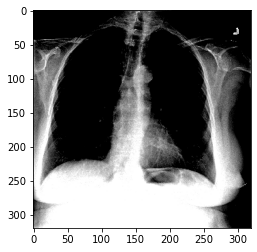

In [56]:
x, y = train_generator.__getitem__(100)
## x is a batch of 8 images with 14 classes each

print(x.shape, y.shape)
plt.imshow(x[0]);

<a name='3'></a>
## 3 Model Development

Now we'll move on to model training and development. We have a few practical challenges to deal with before actually training a neural network, though. The first is class imbalance.

<a name='3-1'></a>
### 3.1 Addressing Class Imbalance
One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets. Let's plot the frequency of each of the labels in our dataset:

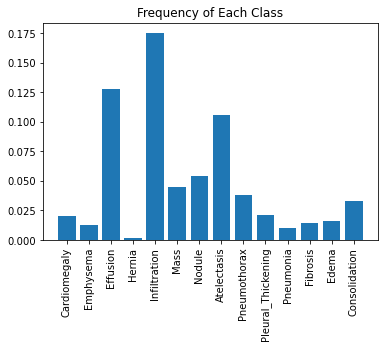

In [58]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

#### Impact of class imbalance on loss function

Let's take a closer look at this. Assume we would have used a normal cross-entropy loss for each pathology. We recall that the cross-entropy loss contribution from the $i^{th}$ training data case is:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

where $x_i$ and $y_i$ are the input features and the label, and $f(x_i)$ is the output of the model, i.e. the probability that it is positive. 

Note that for any training case, either $y_i=0$ or else $(1-y_i)=0$, so only one of these terms contributes to the loss (the other term is multiplied by zero, and becomes zero). 

We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows: 

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is: 

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

<a name='Ex-2'></a>
### Exercise 2 - Computing Class Frequencies
Complete the function below to calculate these frequences for each label in our dataset.

In [65]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.mean(labels, axis = 0)
    negative_frequencies = 1-np.mean(labels, axis = 0)

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [66]:
# Test
labels_matrix = np.array(
    [[1, 0, 0],
     [0, 1, 1],
     [1, 0, 1],
     [1, 1, 1],
     [1, 0, 1]]
)
print("labels:")
print(labels_matrix)

test_pos_freqs, test_neg_freqs = compute_class_freqs(labels_matrix)

print(f"pos freqs: {test_pos_freqs}")

print(f"neg freqs: {test_neg_freqs}")

labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]
pos freqs: [0.8 0.4 0.8]
neg freqs: [0.2 0.6 0.2]


In [67]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

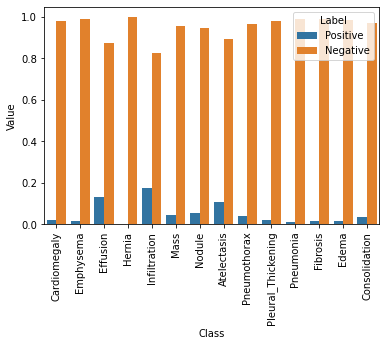

In [68]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

To have this, we want 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [69]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

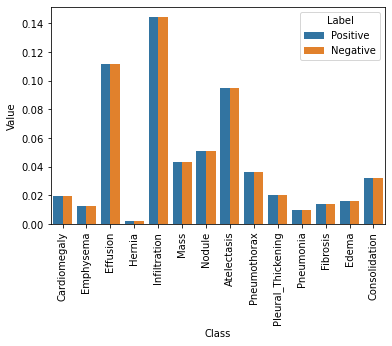

In [73]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)

#data
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

<a name='Ex-3'></a>
### Exercise 3 - Weighted Loss
Fill out the `weighted_loss` function below to return a loss function that calculates the weighted loss for each batch. Recall that for the multi-class loss, we add up the average loss for each individual class. Note that we also want to add a small value, $\epsilon$, to the predicted values before taking their logs. This is simply to avoid a numerical error that would otherwise occur if the predicted value happens to be zero.

##### Note
Please use Keras functions to calculate the mean and the log.

- [Keras.mean](https://www.tensorflow.org/api_docs/python/tf/keras/backend/mean)
- [Keras.log](https://www.tensorflow.org/api_docs/python/tf/keras/backend/log)



In [75]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            p_loss = -1*K.mean(pos_weights[i]*y_true[:,i]*K.log(y_pred[:,i]+epsilon))
            n_loss = -1*K.mean(neg_weights[i]*(1-y_true[:,i])*K.log(1-y_pred[:,i]+epsilon))
            loss += p_loss+n_loss
            
        return loss
    
        ### END CODE HERE ###
    return weighted_loss

<a name='3-3'></a>
### 3.3 DenseNet121

Next, we will use a pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model which we can load directly from Keras and then add two layers on top of it:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers from DenseNet121.
2. A `Dense` layer with `sigmoid` activation to get the prediction logits for each of our classes.

We can set our custom loss function for the model by specifying the `loss` parameter in the `compile()` function.

In [78]:
# create the base pre-trained model
base_model = DenseNet121(weights='Files/nih/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

In [79]:
model.load_weights("Files/nih/pretrained_model.h5")

In [80]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

Instructions for updating:
Please use Model.predict, which supports generators.


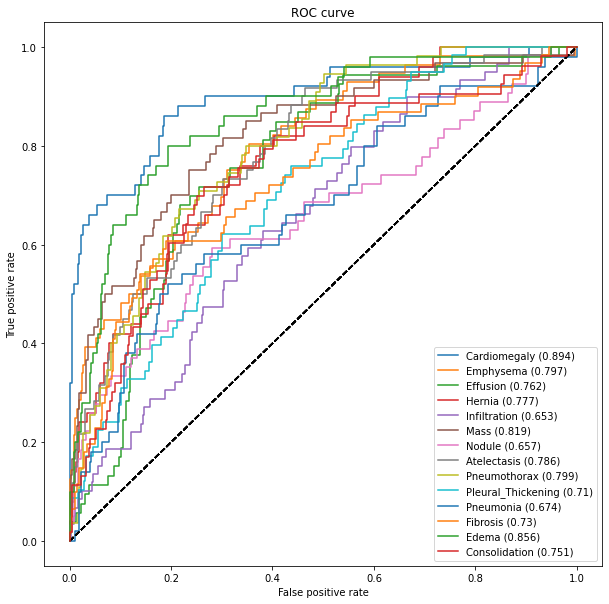

In [81]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)